[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part1/blob/main/MOOC_Notebooks/Notebook06_ComplexMLClassification.ipynb)

# Notebook 06: Complex ML Classification [MOOC Colab Version]

Authors: Randy J. Chase, David R. Harrison, Amanda Burke, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology. Part I: Traditional Machine Learning](https://journals.ametsoc.org/view/journals/wefo/37/8/WAF-D-22-0070.1.xml)<br>
Original Github: [WAF_ML_Tutorial_Part1](https://github.com/ai2es/WAF_ML_Tutorial_Part1)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Burke, A., Lackmann, G. M., & McGovern, A. (2022). A Machine Learning Tutorial for Operational Meteorology. Part I: Traditional Machine Learning, Weather and Forecasting, 37(8), 1509-1529.

### Goal: Training a ML using all features/predictors/inputs

#### Reminder of Problem Statement

Reminder of the ML task we want to accomplish in the paper. 

1. Does this image contain a thunderstorm? <-- Classification
2. How many lightning flashes are in this image? <-- Regression

#### Background

Please make sure you already did Notebook 4, because this notebook extends what we did in Notebook 4 to now include many more input predictors and some additional evaluations/interrogations. 

#### Step 0: Get the github repo (we need some of the functions there)

The first step with all of these Google Colab notebooks will be to grab the github repo and cd into the notebooks directory. 

To run things from the command line, put a ```!``` before your code

In [1]:
#get the github repo 
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part1.git 

#cd into the repo so the paths work 
import os 
os.chdir('/content/WAF_ML_Tutorial_Part1/jupyter_notebooks/')

Cloning into 'WAF_ML_Tutorial_Part1'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 301 (delta 139), reused 236 (delta 96), pack-reused 0
Receiving objects: 100% (301/301), 195.77 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (100/100), done.



#### Step 1 & 2: Import packages and load data for Classification  
In Notebook 4 we only wanted 1 feature, no we want all available inputs (36 total). So all we need to change is the ```features_to_keep``` keyword to include all indices.

In [2]:
#needed packages 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')
from aux_functions import load_n_combine_df
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='../datasets/sevir/',features_to_keep=np.arange(0,36,1),class_labels=True)

Let's print out the shapes of things to make sure they match what we expected, ```[n_samples,n_features]``` for ```X``` and ```[n_samples]``` for ```y```

In [3]:
print('X_train, y_train shapes: {},{}'.format(X_train.shape,y_train.shape))
print('X_val, y_val shapes: {},{}'.format(X_validate.shape,y_validate.shape))
print('X_test, y_test shapes: {},{}'.format(X_test.shape,y_test.shape))

X_train, y_train shapes: (446307, 36),(446307,)
X_val, y_val shapes: (86291, 36),(86291,)
X_test, y_test shapes: (86296, 36),(86296,)


#### Change from Notebook 4

Since we are using more than 1 input predictor it is important to normalize our predictors. Why is this important? because in reality each one of our inputs have a range of valid values associated with them, and that range could be large (e.g., -100 to 100) or it could be small (e.g., 0,1). The machine learning will weight these inputs quantitatively, so if we use the default scalings, it might be biased to use the larger magnitude predictors more than the small magnitude predictors. To prevent this we will scale the data to have mean 0, and variance 1. You are likely more familiar with the term *standard anomaly* which is the same thing: 

$$ z = \frac{x - \mu}{\sigma} $$

where $\mu$ is the mean of that specific feature and $\sigma$ is the standard deviation, both calculated from the training dataset. We could implement this ourselves, but ```sklearn``` has this built for us: ```sklearn.preprocessing.StandardScaler``` and it works alot like how we fit the machine learning model before.

In [4]:
from sklearn.preprocessing import StandardScaler

#create scaling object 
scaler = StandardScaler()
#fit scaler to training data
scaler.fit(X_train)

#transform feature data into scaled space 
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

#double check that mean is 0 and std is 1. 
np.mean(X_train,axis=0),np.std(X_train,axis=0)

(array([ 4.56472368e-16,  3.53052847e-16,  2.49633326e-17,  6.47008825e-17,
         2.03782307e-18,  6.24083316e-17,  2.36132748e-16, -2.13971423e-16,
        -1.21250473e-16, -7.13238075e-17,  3.44901555e-16,  2.64916999e-16,
         8.86962492e-16, -2.30834408e-15, -4.03361604e-16,  3.12551114e-16,
         4.87803898e-16, -1.91810097e-16, -3.89733663e-17, -2.39444211e-16,
         2.79181761e-16,  1.12080269e-17,  1.46977989e-16,  6.58471580e-17,
        -1.54492462e-16,  1.64936305e-16, -8.58432969e-17, -8.66074806e-18,
        -1.29911221e-17,  2.98031624e-17, -1.96140471e-17, -3.13315297e-17,
        -4.83982980e-18,  7.20243092e-17,  2.62369721e-17,  1.23288296e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]))

Note that e-16 means $\times 10^{-16}$ which is effectively 0. So it has successfully scaled our data to now have mean 0 and std 1. We are now ready to train our machine learning model again.

#### Step 3: Initialize model

To keep consistency with Notebook 4, we will continue using logistic regression

In [5]:
#load model from sklearn
from sklearn.linear_model import LogisticRegression

#initialize, we need to expand the number of iterations to not get a warning about not converging
model = LogisticRegression(max_iter=300)

print(model)

LogisticRegression(max_iter=300)


#### Step 4: Train your ML model! 

And just like that, we are back to being ready to train the model!

In [6]:
model = model.fit(X_train,y_train)

#### Step 5: Evaluate your ML model

Let's see how it did!

In [7]:
from gewitter_functions import get_contingency_table

#get predictions
yhat = model.predict(X_validate)

#the contingency table calculator expects y_true,y_pred
cont_table = get_contingency_table(y_validate,yhat)


#the function returns a dictionary (thats what the curly brackets mean) of each entry in the table. 
print(cont_table)

{'num_true_positives': 42505, 'num_false_positives': 4814, 'num_false_negatives': 3294, 'num_true_negatives': 35678}


In [8]:
from gewitter_functions import get_acc
accuracy = get_acc(cont_table)
print('Accuracy = {}%'.format(np.round(accuracy,0)))

Accuracy = 91.0%


POD:0.93, SR:0.9, CSI:0.84


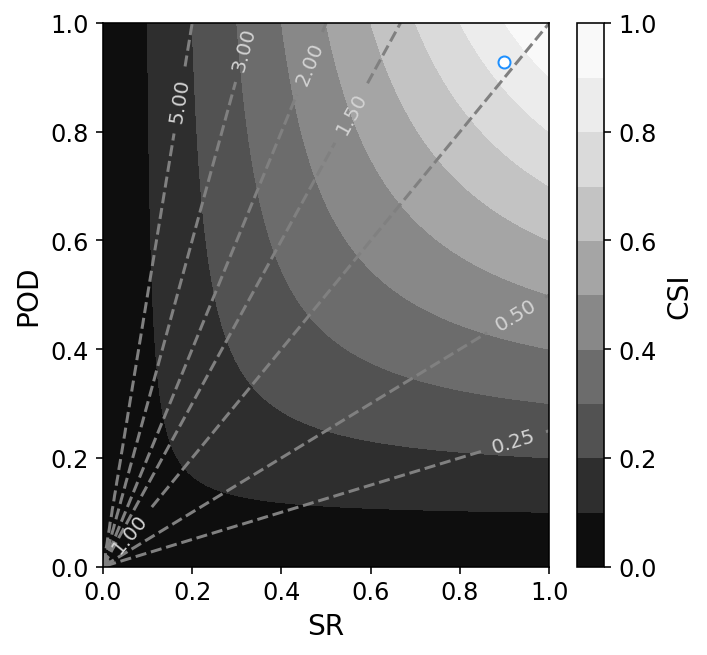

In [9]:
from gewitter_functions import get_pod,get_sr,csi_from_sr_and_pod
pod = get_pod(cont_table)
sr = get_sr(cont_table)
csi = csi_from_sr_and_pod(sr,pod)

print('POD:{}, SR:{}, CSI:{}'.format(np.round(pod,2),np.round(sr,2),np.round(csi,2)))

from gewitter_functions import make_performance_diagram_axis
ax = make_performance_diagram_axis()
ax.plot(sr,pod,'o',color='dodgerblue',markerfacecolor='w');

Amazing, we have achieved 91% accuracy and a CSI > 0.8. These are really good results. 

One thing you might encounter while reading about other machine learning results is a *line* on this performance diagram. For example see this figure from [Lagerquist et al. 2020](https://journals.ametsoc.org/view/journals/mwre/148/7/mwrD190372.xml)

<img src="https://drive.google.com/uc?id=1gzKv4UiLapmXq8ShncZO27QhWfzbziPc" width="400" height="400" class="center" />



Well, what we have been showing so far is the ```model.predict``` output, which is actually doing something for us under the hood. The ```model.predict``` line of code is actually running the ```model.predict_proba``` which outputs a probability of each class (i.e., does not contain thunderstorm, contains thunderstorm) and then ```model.predict``` is taking the max of the two columns of probabilities to assign the class. In other words, if the probability of class 0 (no thunderstorm) is less than 0.5, then the label would be 1, and if it was greater than 0.5 it would be 0. This is not a bad place to start, but sometimes we can get better performance by using a different *threshold*.

So the line you see above comes from varying the threshold value for the label. 


We can do this ourselves. Let's first look at ```model.predict_proba```

In [10]:
#get predictions
yhat_proba = model.predict_proba(X_validate)

print('proba:{},label:{}'.format(yhat_proba[0],yhat[0]))

proba:[0.8269921 0.1730079],label:0


As you can see, the predicted probabilities for the first example shows a 90% prediction for no lightning while about 10% for the lightning. So a threshold of 0.5, which is assumed by the ```model.predict()```, shows that the label is indeed a 0 (or no lightning). But, say if our threshold was 95%, then the label would actually be a 1. 

So to create the line we will systematically change the threshold value between 0 and 1. Along the way, we will calculate the contingency table at each threshold value, and then calculate the POD and SR. Doing this results in the line.

To actually implement this, we will use a ```for``` loop.

In [11]:
#a fun progress bar to tack progress
import tqdm

#lets just focus on the output from class 1 (note, the sum of these two columns should be 1)
y_preds = yhat_proba[:,1]
    
#chose you thresholds, this will make 50 evenly spaced points between 0 and 1. 
threshs = np.linspace(0,1,50)

#pre-allocate a vector full of 0s to fill with our results 
pods = np.zeros(len(threshs))
srs = np.zeros(len(threshs))
csis = np.zeros(len(threshs))

#for each threshold!
for i,t in enumerate(tqdm.tqdm(threshs)):
    #make a dummy binary array full of 0s
    y_preds_bi = np.zeros(y_preds.shape,dtype=int)
    
    #find where the prediction is greater than or equal to the threshold
    idx = np.where(y_preds >= t)
    #set those indices to 1
    y_preds_bi[idx] = 1
    #get the contingency table again 
    table = get_contingency_table(y_validate,y_preds_bi)
    #calculate pod, sr and csi 
    pods[i] = get_pod(table)
    srs[i] = get_sr(table)
    csis[i] = csi_from_sr_and_pod(sr,pod)

100%|██████████| 50/50 [00:00<00:00, 474.76it/s]


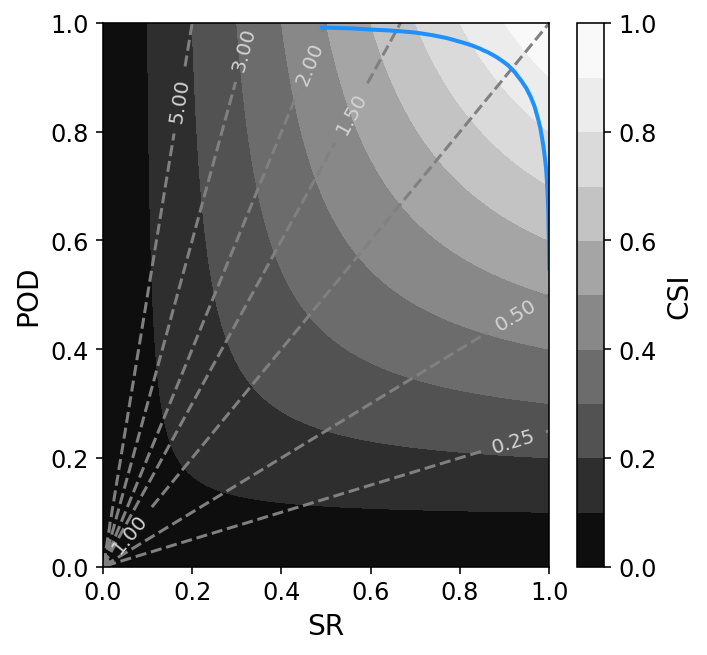

In [12]:
ax = make_performance_diagram_axis()
ax.plot(srs,pods,'-',color='dodgerblue',markerfacecolor='w',lw=2);

Now you can see where the line comes from. You might be asking what the purpose of the line is? Well for some instances, your trained ML model might be biased (above or below the diagonal). Thus, this could be a way to achieve better performance without having to adjust the training of the model. All you would have to change (i.e., *calibrate*) is the threshold probability to something other than 0.5 to get better results.

##### Additional Metric: AUC of the ROC curve

Along the same lines as we just did, where we varied the threshold of prediction, there is another metric and diagram that is often used in ML for classification: the Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) curve. The ROC curve is plotted by calculating one of the same axes as the performance diagram, POD

$$ \mathrm{POD} = \frac{TruePositives}{TruePositives + FalseNegatives} $$

but now the x-axis is the probability of false detection

$$ \mathrm{POFD} = \frac{FalsePositives}{FalsePositives + TrueNegatives} $$

Since we need to get the area under the ROC curve (i.e., integrate), we have built a couple functions that handle this for you named ```get_points_in_roc_curve``` and ```get_area_under_roc_curve``` located in the ```gewitter_functions.py``` script.

In [13]:
from gewitter_functions import get_points_in_roc_curve,get_area_under_roc_curve

#lets just focus on the output from class 1 (note, the sum of these two columns should be 1)
y_preds = yhat_proba[:,1]
    
pofds, pods = get_points_in_roc_curve(forecast_probabilities=y_preds, observed_labels=y_validate, threshold_arg=np.linspace(0,1,100))

AUC: 0.97


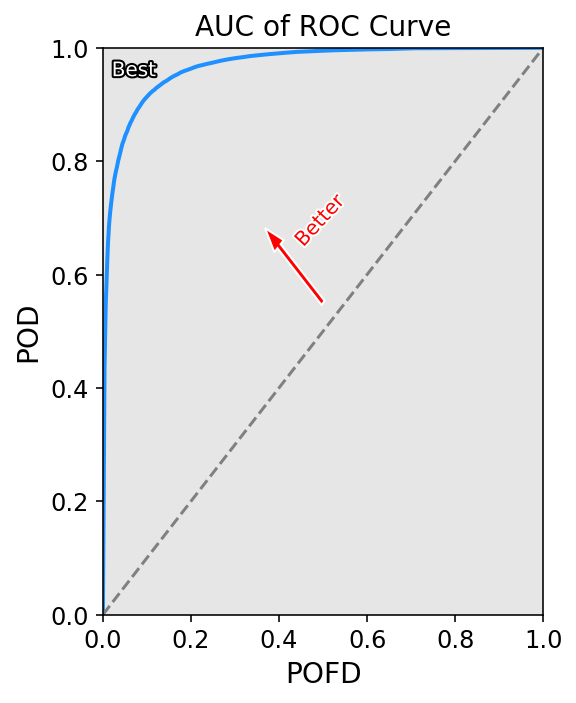

In [15]:
#something to help with annotating the figure
import matplotlib.patheffects as path_effects
pe = [path_effects.withStroke(linewidth=2,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=2,
                             foreground="w")]
    
#make figure
fig = plt.figure(figsize=(4.1,5))
#set facecolor to white so you can copy/paste the image somewhere 
fig.set_facecolor('w')

#plot the ROC curve
plt.plot(pofds,pods,color='dodgerblue',markerfacecolor='w',lw=2);

#some annotations
plt.arrow(0.5, 0.55, -0.1, 0.1,facecolor='r',zorder=5,width=0.01,edgecolor='w')
plt.text(0.43,0.65,'Better',rotation=47.5,color='r',path_effects=pe2)
plt.text(0.02,0.95,'Best',color='w',path_effects=pe,zorder=5)

#set some limits
plt.xlim([0,1])
plt.ylim([0,1])

#set the no-skill line
plt.plot([0,1],[0,1],'--',color='Grey')

#label things
plt.title("AUC of ROC Curve")
plt.xlabel('POFD')
plt.ylabel('POD')

plt.tight_layout()

#print out the AUC value
print("AUC: {}".format(np.round(get_area_under_roc_curve(pofds,pods),2)))

A perfect performing model will have an AUC of 1. Since the AUC with this model is 0.97, that is really good. Visually to inspect this diagram, the closer the line is found in the top left corner, the better the model is performing. Meanwhile if your line is near the diagonal, then you model has little to no skill (AUC 0.5).